In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib
framer = pd.DataFrame()

matplotlib.rcParams['svg.fonttype'] = 'none'

In [2]:
#Metabolic Gene list obtained unaltered from supplemental table 2 of DOI:https://doi.org/10.1016/j.celrep.2018.03.077

MetGene = "/Users/brooksleitner/Desktop/Python/PerryLabData/metabolicgenelists/metabolicsuperpathwaygenelist.xlsx"

aminoacids = pd.read_excel(MetGene, sheet_name=0, header=1)
carbohydrates = pd.read_excel(MetGene, sheet_name=1, header=1)
energy = pd.read_excel(MetGene, sheet_name=2, header=1)
lipid = pd.read_excel(MetGene, sheet_name=3, header=1)
nucleotide = pd.read_excel(MetGene, sheet_name=4, header=1)
tca = pd.read_excel(MetGene, sheet_name=5, header=1)
vitamin = pd.read_excel(MetGene, sheet_name=6, header=1)

allpathways = aminoacids.append([carbohydrates, energy, tca])

In [58]:
MasterData = pd.read_csv('/Users/brooksleitner/Desktop/Python/PerryLabData/ExerciseCancer/GSE62628MelanomaExerciseTumors/MelanomaMasterFile.csv')
Subjects = pd.read_csv('/Users/brooksleitner/Desktop/Python/PerryLabData/ExerciseCancer/GSE62628MelanomaExerciseTumors/MelanomaIndividualSubjects.csv')

In [4]:
SubjectData = pd.merge(MasterData, Subjects, on="ID", how='inner')

In [5]:
exercise = ['GSM1530453','GSM1530454','GSM1530455','GSM1530456','GSM1530457']
sedentary = ['GSM1530458','GSM1530459','GSM1530460','GSM1530461','GSM1530462']

In [6]:
#Clean up data to drop NaN

SubjectData = SubjectData.dropna()
SubjectData = SubjectData[SubjectData['adj.P.Val'] < 0.05]

#if duplicates in Gene.symbol, select just the most significant one (if multiple probes
#identify the same gene choose the probe with the lowest p value)

SubjectData = SubjectData.sort_values('adj.P.Val').drop_duplicates('Gene.symbol', keep='first')

In [7]:
ClusterMapData = SubjectData[['Gene.symbol', 'GSM1530453','GSM1530454','GSM1530455','GSM1530456',
'GSM1530457','GSM1530458','GSM1530459','GSM1530460','GSM1530461','GSM1530462']]

In [8]:
ClusterMapData.rename(columns={'Gene.symbol': 'Genes'}, inplace=True)

/Users/brooksleitner/opt/anaconda3/envs/sepsismetabolism/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [9]:
#This converts the genes from mouse to human nomenclature
#The mouse orthologues of all genes used in further analyses were confirmed
#in the NCBI GenBank Database (https://www.ncbi.nlm.nih.gov/genbank/)


ClusterMapData['Genes'] = ClusterMapData['Genes'].str.upper()

/var/folders/63/kvjwtxbn1hqfmqdmm3m1gg0r0000gn/T/ipykernel_17908/3824678430.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ClusterMapData['Genes'] = ClusterMapData['Genes'].str.upper()


In [10]:
SLCClusterMapData = ClusterMapData[ClusterMapData['Genes'].str.contains('SLC')]

In [11]:
SLCClusterMapData['Pathway'] = 'Solute Carrier'

/var/folders/63/kvjwtxbn1hqfmqdmm3m1gg0r0000gn/T/ipykernel_17908/727956508.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SLCClusterMapData['Pathway'] = 'Solute Carrier'


In [12]:
GenesAndPathways = pd.merge(ClusterMapData, allpathways, on='Genes', how='inner')

In [13]:
GenesAndPathways = GenesAndPathways.append([SLCClusterMapData])
GenesAndPathways_forEnr = GenesAndPathways.drop_duplicates(subset=['Genes'])

In [15]:
#GenesAndPathways_forEnr.to_csv('../genelists/MetabolicgenelistforEnrichr.csv')

#Moved to perform enrichr analysis on Ma'ayan web page
#https://maayanlab.cloud/Enrichr/


In [16]:
#This is the dataframe I will use for the Volcano plot

GenesAndPathways1 = GenesAndPathways.drop_duplicates(subset=['Genes'])
GenesAndPathways1.set_index('Genes', inplace = True)

In [18]:
pathway = GenesAndPathways1.pop('Pathway')

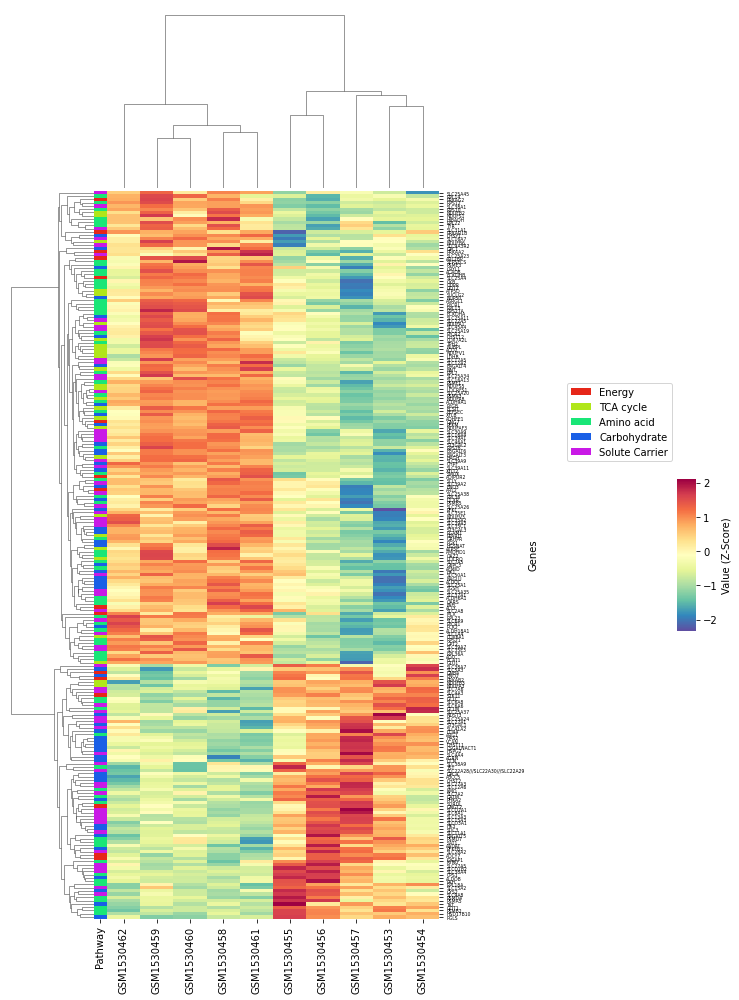

In [19]:
lut = dict(zip(pathway.unique(), sns.hls_palette(len(set(pathway)), l=0.5, s=0.8)))
row_colors = pathway.map(lut)
g = sns.clustermap(GenesAndPathways1, z_score=0, figsize=(9, 14),
                   cbar_pos=(1.05, 0.37, .03, 0.15),
                   cbar_kws={"label" : "Value (Z-Score)"},
                   row_colors=row_colors, cmap='Spectral_r',
                   yticklabels=True,
                   xticklabels=True)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 4.5)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 10)
for label in pathway.unique():
    g.ax_col_dendrogram.bar(0, 0, color=lut[label],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(bbox_to_anchor=(1.70, -1.5), loc='lower right', borderaxespad=0, ncol=1)
#g.savefig('/Users/brooksleitner/Desktop/Python/PerryLabData/ExerciseCancer/ExerciseCancerMouseData/figures/DEG_Melanoma_Clustermap.svg', bbox_inches="tight", dpi=300)

# Volcano Plot

In [59]:
#a little cleaning
MasterData = MasterData.dropna()
MasterData = MasterData[MasterData['adj.P.Val'] < 0.05]

In [60]:
#Prepare Data for scatterplot in Seaborn

MasterData['logadjP'] = -(np.log2(MasterData['adj.P.Val']))

#Make column to identify prognostic genes
LeuGlnChanneling = ['Slc7a5', 'Slc25a1', 'Bckdha', 'Bckdhb', 'Idh1', 'Bcat1', 'Gpt2','Slc38a1', 'Pycr1', 'Uqcrfs1', 'Got2']

MasterData['Channeling'] = 'Regular'
MasterData['Channeling'][MasterData['Gene.symbol'].str.contains('Slc7a5')] = 'Leu/Gln Channeling'
MasterData['Channeling'][MasterData['Gene.symbol'].str.contains('Slc25a1')] = 'Leu/Gln Channeling'
MasterData['Channeling'][MasterData['Gene.symbol'].str.contains('Bckdha')] = 'Leu/Gln Channeling'
MasterData['Channeling'][MasterData['Gene.symbol'].str.contains('Bckdhb')] = 'Leu/Gln Channeling'
MasterData['Channeling'][MasterData['Gene.symbol'].str.contains('Idh1')] = 'Leu/Gln Channeling'
MasterData['Channeling'][MasterData['Gene.symbol'].str.contains('Bcat1')] = 'Leu/Gln Channeling'
MasterData['Channeling'][MasterData['Gene.symbol'].str.contains('Gpt2')] = 'Leu/Gln Channeling'
MasterData['Channeling'][MasterData['Gene.symbol'].str.contains('Slc38a1')] = 'Leu/Gln Channeling'
MasterData['Channeling'][MasterData['Gene.symbol'].str.contains('Pycr1')] = 'Leu/Gln Channeling'
MasterData['Channeling'][MasterData['Gene.symbol'].str.contains('Uqcrfs1')] = 'Leu/Gln Channeling'
MasterData['Channeling'][MasterData['Gene.symbol'].str.contains('Got2')] = 'Leu/Gln Channeling'


/var/folders/63/kvjwtxbn1hqfmqdmm3m1gg0r0000gn/T/ipykernel_17908/1116424555.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MasterData['Channeling'][MasterData['Gene.symbol'].str.contains('Slc7a5')] = 'Leu/Gln Channeling'
/var/folders/63/kvjwtxbn1hqfmqdmm3m1gg0r0000gn/T/ipykernel_17908/1116424555.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MasterData['Channeling'][MasterData['Gene.symbol'].str.contains('Slc25a1')] = 'Leu/Gln Channeling'
/var/folders/63/kvjwtxbn1hqfmqdmm3m1gg0r0000gn/T/ipykernel_17908/1116424555.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

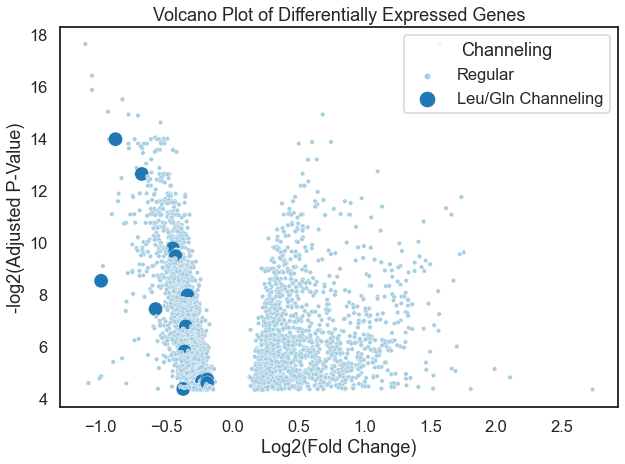

In [31]:
#Try a Seaborn Scatterplot
sns.set(style='white', context='talk', rc={'figure.figsize':(10,7)})
g = sns.scatterplot(data=MasterData, x="logFC", y="logadjP", 
                hue="Channeling", palette='Paired',
                #hue_order=
                size='Channeling', sizes=(200,20),
                size_order=('Regular', 'Leu/Gln Channeling'),
               )
g.set_xlabel("Log2(Fold Change)") 
g.set_ylabel("-log2(Adjusted P-Value)")
g.set_title("Volcano Plot of Differentially Expressed Genes")
plt.rcParams['pdf.fonttype'] = 42
plt.savefig('/Users/brooksleitner/Desktop/Python/PerryLabData/ExerciseCancer/ExerciseCancerMouseData/figures/ExerciseMelanomaVolcano.svg', dpi=300, bbox_inches='tight')

# Human Breast Cancer

In [32]:
#Dataframe that contains all subjects and all log2CPM TMM normalized gene expression data

BreastData = pd.read_csv('/Users/brooksleitner/Desktop/Python/PerryLabData/ExerciseCancer/IrwinStudy/HumanBreastCancer/log2normalizedexpression_Irwinstudy.csv')

In [33]:
#define subjects based on labels
SubjectID = pd.read_csv('/Users/brooksleitner/Desktop/Python/PerryLabData/ExerciseCancer/IrwinStudy/BreastCancerExerciseSubjects.csv', encoding='latin-1')
Exercise = SubjectID[SubjectID['Condition'] == 'exercise']

In [34]:
#Create subset of subjects that includes log2CPM gene expression data and the Gene label
PreExercise = Exercise[Exercise['Time'] == 'pre']
PostExercise = Exercise[Exercise['Time'] == 'post']

PreExGenes = BreastData[[subject for subject in PreExercise['GEO_ID'].tolist()
                         if subject in list(BreastData)] + ['Gene']]

PostExGenes = BreastData[[subject for subject in PostExercise['GEO_ID'].tolist()
                         if subject in list(BreastData)] + ['Gene']]

In [41]:
#Targeted analysis:

LeuGlnChanneling = [x.upper() for x in LeuGlnChanneling]

In [42]:
#Subset of Carbohydrate Metabolism Genes

#Pre
premasker = PreExGenes['Gene'].isin(LeuGlnChanneling)
pregenes = PreExGenes[premasker]

#post
postmasker = PostExGenes['Gene'].isin(LeuGlnChanneling)
postgenes = PostExGenes[postmasker]

#the gene list for each is the same, so can do this
channelgenes = pregenes['Gene'].tolist()

#delete the genes column so we can work with the numbers alone for statistical tests

del pregenes['Gene']
del postgenes['Gene']

#Get all of the values into a list format for statistical tests

pregenes_vals = pregenes.values.tolist()
postgenes_vals = postgenes.values.tolist()

In [43]:
ps = []
ts = []
mean_pre_ex = []
mean_post_ex = []

for x, y, z in zip(channelgenes, pregenes_vals, postgenes_vals):
    ps.append(stats.ttest_ind(y,z, equal_var=False)[1])
    ts.append(stats.ttest_ind(y,z, equal_var=False)[0])
    mean_pre_ex.append(np.mean(y))
    mean_post_ex.append(np.mean(z))
    
postvpre = framer.append(channelgenes)
postvpre['t'] = ts
postvpre['p'] = ps
postvpre['pre_mean'] = mean_pre_ex
postvpre['post_mean'] = mean_post_ex
postvpre['log2FC'] = postvpre['post_mean'] - postvpre['pre_mean']

postvpre = postvpre.sort_values('log2FC')

# MetaMex Genes

In [47]:
metamex = pd.read_csv('/Users/brooksleitner/Desktop/Python/PerryLabData/ExerciseCancer/genelists/MetaMexGeneList.csv', header=2)

In [79]:
#Get a dataframe with only the logFC values

metalogFC = metamex[['Gene', 'AcuteAerobic_LogFC', 'AerobicTraining_LogFC', 
                     'AcuteResistance_LogFC',
                     'ResistanceTrain_LogFC', 
                     'AcuteHIT_LogFC', 'HITTrain_LogFC',
                    #'Inactivity_LogFC'
                    ]]

# Combine Mouse Tumor, Human Tumor, and Human Muscle Gene Expression

In [93]:
#Human Breast Cancer Genes
human_breast = postvpre[[0, 'log2FC']]
human_breast = human_breast.rename({0: 'Gene', 'log2FC': 'human_breast_log2FC'}, axis=1) 

In [99]:
#Mouse Tumor Genes
mouse_tumor = MasterData[MasterData['Channeling'] == 'Leu/Gln Channeling'][['Gene', 'logFC']]
mouse_tumor = mouse_tumor.rename({'logFC': 'mouse_tumor_logFC'}, axis=1)

In [100]:
#First Merge
combo = metalogFC.merge(human_breast, on='Gene')

In [104]:
all_combinations = combo.merge(mouse_tumor, on='Gene').drop_duplicates('Gene')

In [109]:
all_combinations_forplot = all_combinations.set_index('Gene')

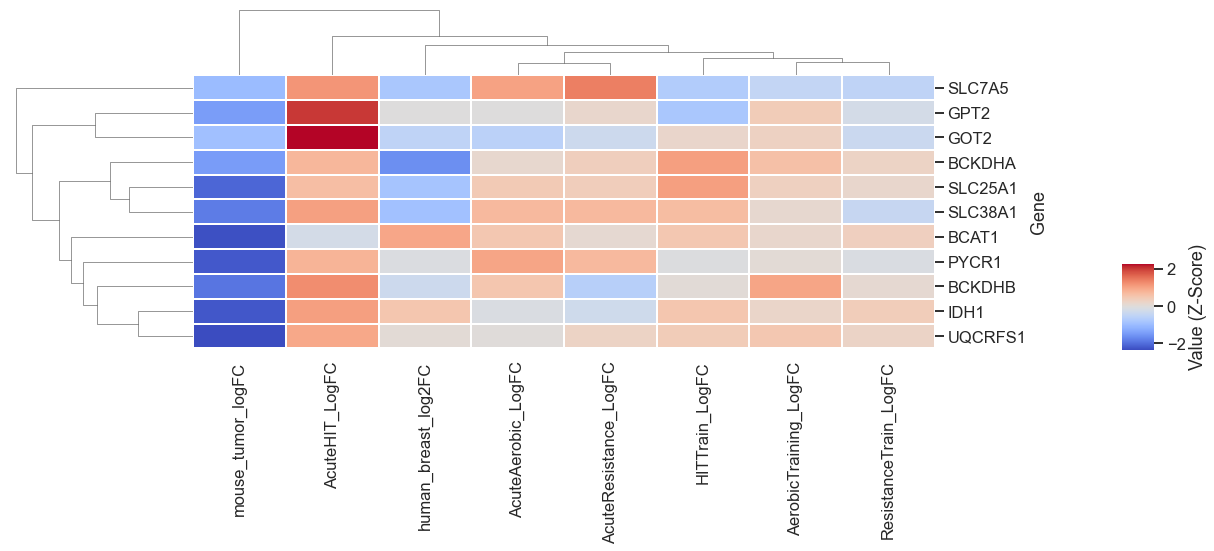

In [111]:
#Make heatmap with genes for each log FC, and Zscore across rows to highlight differences across conditions

g = sns.clustermap(all_combinations_forplot, z_score=0, figsize=(15, 8),
                   cbar_pos=(1.05, 0.37, .03, 0.15),
                   cbar_kws={"label" : "Value (Z-Score)"},
                   #row_colors=row_colors, 
                   linewidths = 2,
                   #col_cluster=False,
                   cmap='coolwarm')
#for label in pathway.unique():
#    g.ax_col_dendrogram.bar(0, 0, color=lut[label],
#                            label=label, linewidth=0)
#g.ax_col_dendrogram.legend(bbox_to_anchor=(1.70, -1.5), loc='lower right', borderaxespad=0, ncol=1)
g.savefig('/Users/brooksleitner/Desktop/Python/PerryLabData/ExerciseCancer/ExerciseCancerMouseData/figures/Metamex_Clustermap_plusBreast.svg', bbox_inches="tight", dpi=300)